# Master Kernel
##### Tiempo estimado de corrida: XX
___
### Análisis Exploratorio

##### Integrantes:
+ Alvarado, Rubén
+ Penovi, Francisco

In [2]:
############################ROOT#############################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

STATUS_CSV = '../DataSet/status.csv'
STATION_CSV = '../DataSet/station.csv'
TRIP_CSV = '../DataSet/trip.csv'
WEATHER_CSV = '../DataSet/weather.csv'

dfStation = pd.read_csv(STATION_CSV, parse_dates=['installation_date'], infer_datetime_format=True)
# dfStatus = pd.read_csv(STATUS_CSV)   OJO CON ESTE QUE ES MUY PESADO
dfTrip = pd.read_csv(TRIP_CSV, parse_dates=['start_date', 'end_date'], infer_datetime_format=True)
dfWeather = pd.read_csv(WEATHER_CSV, parse_dates=['date'], infer_datetime_format=True)

''' Recibe un plot de barras y les asigna sus valores
    encima de cada una de ellas. Se puede setear textsize y alpha.'''
def autolabel(ax, textsize, alpha):
    # Get y-axis height to calculate label position from.
    (y_bottom, y_top) = ax.get_ylim()
    y_height = y_top - y_bottom

    for rect in ax.patches:
        height = rect.get_height()
        label_position = height + (y_height * 0.01)

        ax.text(rect.get_x() + rect.get_width()/2., label_position,
                '%d' % int(height),
                ha='center', va='bottom', size=textsize, alpha=alpha)


''' Utilizada como parámetro para función DataFrame.apply
    Para cada row, devuelve el zip code correspondiente a la ciudad.'''
def cityNameToZipCode(row) :

    if row.city == 'San Francisco' :
        return '94107'

    if row.city == 'Redwood City' :
        return '94063'

    if row.city == 'Palo Alto' :
        return '94301'

    if row.city == 'Mountain View' :
        return '94041'

    if row.city == 'San Jose' :
        return '95113'

    raise ValueError('Malo malo!')


''' Utilizada para generar un DataFrame nuevo que contiene las filas de la ciudad
    pasada por parámetro únicamente.'''
def makeNewDataFrameWithCity(df, city) :

    dic = {'date':[], 'city':[], 'zip_code':[], 'duration':[], 'max_temp_f':[], 'min_temp_f':[]}

    for i in range(0, len(df)):
        if (df.iloc[i]['city'] == city ) :
            dic['date'].append(df.iloc[i]['date'])
            dic['city'].append(df.iloc[i]['city'])
            dic['zip_code'].append(df.iloc[i]['zip_code'])
            dic['duration'].append(df.iloc[i]['duration'])
            dic['max_temp_f'].append(df.iloc[i]['max_temperature_f'])
            dic['min_temp_f'].append(df.iloc[i]['min_temperature_f'])

    return pd.DataFrame.from_dict(data=dic, orient='columns')


''' Utilizada para clasificar en grupos a las horas del día.'''
def getMomentOfDay(row):

    if row.hour < 5:
        return 'Small Hours'
    if  5 <= row.hour < 12:
        return 'Morning'
    if 12 <= row.hour < 14:
        return 'Noon'
    if 14 <= row.hour < 18:
        return 'Afternoon'
    if 18 <= row.hour < 21:
        return 'Evening'
    if 21 <= row.hour <= 23:
        return 'Night'

###############################ENDROOT#############################

### ----- INICIO NOTEBOOK 01 -----

### Subscription Type VS Trip Duration

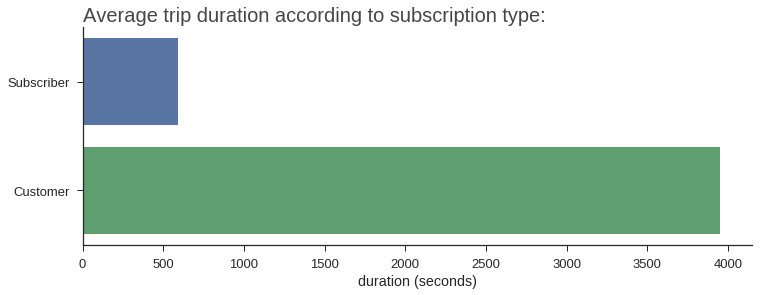

In [4]:
result = dfTrip[['duration', 'start_date', 'end_date', 'subscription_type']]\
        .sort_values(by=['start_date', 'end_date'])\
        .groupby(by=['subscription_type'])\
        .agg('mean').reset_index()
        
plt.figure(figsize=(12,4))

sns.set(font_scale=1.30)
sns.set_style('ticks')

bars = sns.barplot(x='duration',\
                   y='subscription_type',\
                   order=['Subscriber', 'Customer'],\
                   data=result)

sns.despine()

bars.set(xlabel='duration (seconds)',\
         ylabel='');

bars.set_title('Average trip duration according to subscription type:', size=20, loc='left', alpha=0.85);
plt.show()

### Observo la varianza de las duraciones
Para realizar recortes de volúmenes de datos muy pequeños pero con valores muy altos o muy bajos que alteran la naturaleza de los datos.

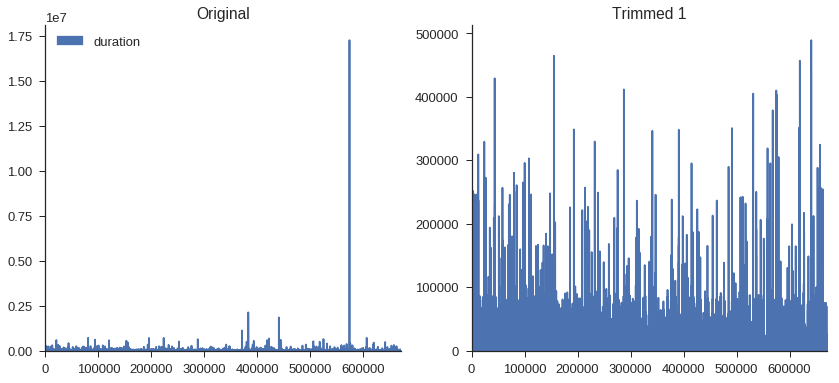

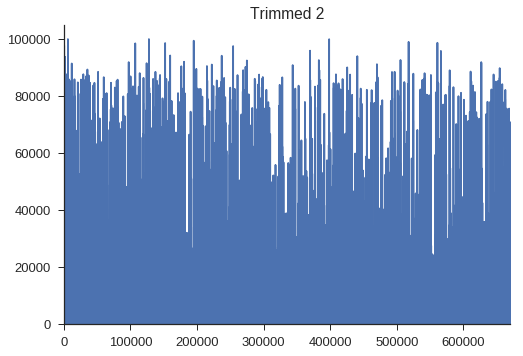

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2)

fig.set_size_inches(14, 6)

sns.despine()

dfTrip['duration'].plot(ax=axes[0], kind='area', legend=True);
axes[0].set_title('Original');
dfTrip[(60*2 <= dfTrip.duration) & (dfTrip.duration <= 500000)][['duration']].plot(ax=axes[1], kind='area', legend=False);
axes[1].set_title('Trimmed 1');
dfTrip[(60*2 <= dfTrip.duration) & (dfTrip.duration <= 100000)][['duration']].plot(kind='area', legend=False).set_title('Trimmed 2');

sns.despine()

plt.show();

**Para facilitar la comprensión de la dispersión de los datos (ya que en los gráficos no se puede apreciar)  
voy a armar un nuevo DataFrame con la cantidad de viajes dentro de los intervalos existentes.**

In [6]:
# Armo intervalos de duracion y me fijo cual es el intervalo más común
durationIntervals = {}
maxDuration = dfTrip.duration.max()
minDuration = dfTrip.duration.min()

while ( maxDuration >= 120) :    
    interval = (maxDuration/2 + 1, maxDuration)
    durationIntervals[interval] = 0
    maxDuration /= 2

durationIntervals[(minDuration, maxDuration)] = 0

# Cuento la cantidad de trips en cada intervalo y relleno el diccionario:
for interval in durationIntervals.keys() :
    durationIntervals[interval] = dfTrip[(interval[0] <= dfTrip.duration) & (dfTrip.duration <= interval[1])]\
                                        .duration.count()

In [7]:
dfIntervals = pd.DataFrame.from_dict(durationIntervals, orient='index').reset_index()
dfIntervals.columns = ['interval', 'trips']
dfIntervals.sort_values(by=['interval'], inplace=True)
dfIntervals

,interval,trips
10,"(60, 65)",305
15,"(66, 131)",7274
4,"(132, 263)",82834
18,"(264, 527)",254285
5,"(528, 1054)",246085
0,"(1055, 2108)",48838
14,"(2109, 4216)",11213
1,"(4217, 8432)",8361
8,"(8433, 16865)",6203
13,"(16866, 33731)",3117


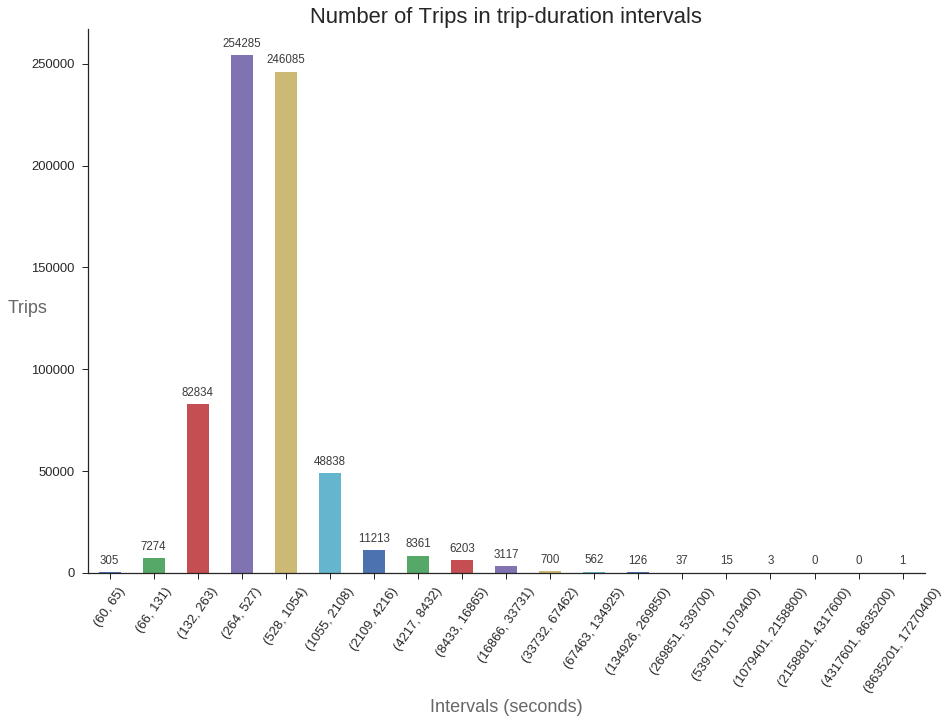

In [8]:
ax = dfIntervals.plot(kind='bar', x='interval', y='trips', color=sns.color_palette(), legend=False)
ax.figure.set_size_inches(15, 10)

sns.despine()
ax.set_title('Number of Trips in trip-duration intervals', size=22)
ax.set_xlabel('Intervals (seconds)', size=18, alpha=0.7)
ax.set_ylabel('Trips', size=18, rotation='horizontal', position=(0, 0.47), alpha=0.7)
plt.xticks(rotation=55, size=13)

autolabel(ax, 11.5, 0.9)      # Definida en root.py

plt.show()

### Recorto viajes menores a 2 minutos y mayores a 6 horas
Podemos observar en el gráfico de arriba que las duraciones más comunes de los viajes estan entre el rango de **4** a **17** minutos.  
Existen viajes extremadamente largos (200 días por ejemplo) que alteran los promedios de los viajes al igual que viajes extremadamente cortos que no representan casos habituales en el set de datos y perjudican a la comprensión y generalización de los mismos.

**De hecho en la página oficial el uso extendido de las bicicletas es desalentado para este servicio:**
> *"If you plan on using a bicycle for an extended period of time,
> we encourage you to rent a bike at a local bike shop or 
> rental business."*

In [10]:
lendfTrip = len(dfTrip)

###################################################################
# Filtro dfTrip por viajes de duracion entre 2 y 6 horas

dfTrip = dfTrip[(2*60 <= dfTrip.duration) & (dfTrip.duration <= 6*3600)]

###################################################################

print "\nAntes del recorte:", lendfTrip, "\nDespués del recorte:", len(dfTrip), "\n"
print "Datos perdidos:", '%' + str(100 - (len(dfTrip) / float(lendfTrip))*100.0)


Antes del recorte: 669959 
Después del recorte: 661556 

Datos perdidos: %1.25425585745


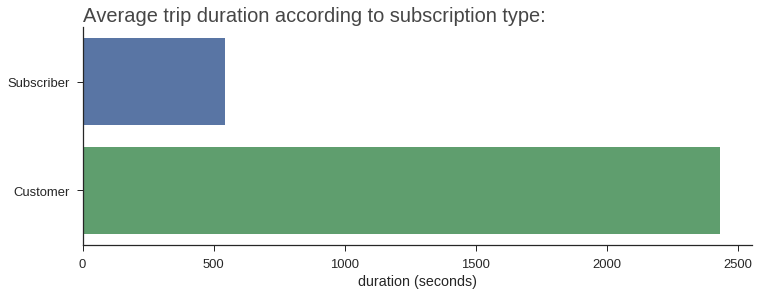

In [11]:
result = dfTrip[['duration', 'start_date', 'end_date', 'subscription_type']]\
        .sort_values(by=['start_date', 'end_date'])\
        .groupby(by=['subscription_type'])\
        .agg('mean').reset_index()
        
plt.figure(figsize=(12,4))

sns.set(font_scale=1.30)
sns.set_style('ticks')

bars = sns.barplot(x='duration',\
                   y='subscription_type',\
                   order=['Subscriber', 'Customer'],\
                   data=result)

sns.despine()

bars.set(xlabel='duration (seconds)',\
         ylabel='');

bars.set_title('Average trip duration according to subscription type:', size=20, loc='left', alpha=0.85);
plt.show()

Se puede apreciar que los valores de los **suscriptos** se mantienen iguales mientras que las duraciones de los viajes de los **clientes** rondan los 45 minutos, en oposición al gráfico anterior en donde éstos últimos sobrepasaban la hora.

Esto cobra un sentido más trascendente cuando se lo observa a la par con los precios listados en la página oficial:  
[SF Bay Area Bike Share](https://www.bayareabikeshare.com/pricing "Bay Area Bike Pricing") en donde se puede observar que a partir de los 30+ minutos de viaje, comienzan a haber pequeños recargos y luego de los 60+ minutos de viaje los recargos aumentan. Por lo que tiene sentido que en promedio los viajes no se excedan de los 60 minutos.

### ----- FIN NOTEBOOK 01 -----

___

### ----- INICIO NOTEBOOK 01 -----

### Temperature VS Trip Duration
**Analizando el DataFrame de Weather:**

In [13]:
dfWeather.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

In [14]:
dfWeather[dfWeather.date == pd.to_datetime('2013-08-29', format='%Y-%m-%d')][['date', 'zip_code']]

,date,zip_code
0,2013-08-29,94107
184,2013-08-29,94063
368,2013-08-29,94301
552,2013-08-29,94041
736,2013-08-29,95113


**Observamos que para cada fecha tenemos pronósticos de 5 zipcodes distintos:**  
Investigando, los zipcodes se corresponden de la siguiente manera

+ 94107 --> San Francisco
+ 94063 --> Redwood City
+ 94301 --> Palo Alto
+ 94041 --> Mountain View
+ 95113 --> San Jose

### Analizando el Dataframe de Trips
**Mientras que los zipcodes de la tabla Trips son de los usuarios que usan las bicis:**

In [15]:
print dfTrip.zip_code.unique()
print "Zip Codes distintos:", dfTrip.zip_code.unique().size

['94109' '95112' '94041' ..., '2280' '9240' '29609']
Zip Codes distintos: 7240


Por ejemplo:

+ 94109   --> San Francisco
+ 95112   --> San Jose
+ 94041   --> Mountain View
+ 2280    --> Bélgica
+ 9240    --> Bélgica
+ 29609   --> Greenville

*Estos zip codes en principio no nos servirían para nada más que para saber de donde es la persona que realizó el viaje*

**Las ciudades en las que se encuentran las estaciones son las mismas de las que tenemos información meteorológica:**  
Esto implica que podremos vincular el dato de la duración de un viaje en particular por su start_station_id con una estación en la tabla de stations y así con una ciudad y su información meteorológica.

In [16]:
dfStation.city.unique()

array(['San Jose', 'Redwood City', 'Mountain View', 'Palo Alto',
       'San Francisco'], dtype=object)

### Ploteando :
Voy a necesitar una tabla con estos datos:

| Trip_date     | Duration      | min_temp  | max_temp
|:-------------:|:-------------:|:---------:|:--------:
| XXXX-XX-XX    | xxx           | xx °F     | xx °F

Donde Duration va a ser la media/mediana o el promedio de los viajes en ese dia.
Podria hacer un multiplot para los 5 zipcodes

In [18]:
dfTrip_N_Weather = dfTrip[['duration', 'start_date', 'start_station_id']]
dfTrip_N_Weather.rename(columns={'start_station_id':'id'}, inplace=True)
dfTrip_N_Weather = dfTrip_N_Weather.merge(dfStation[['id', 'city']], on=['id'])

/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:2834: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [19]:
dfTrip_N_Weather.sort_values(by='duration')
dfTrip_N_Weather['zip_code'] = dfTrip_N_Weather.apply(cityNameToZipCode, axis=1)
dfTrip_N_Weather.head()

,duration,start_date,id,city,zip_code
0,125,2013-08-29 13:52:00,49,San Francisco,94107
1,146,2013-08-29 19:42:00,49,San Francisco,94107
2,424,2013-08-29 17:42:00,49,San Francisco,94107
3,459,2013-08-29 18:28:00,49,San Francisco,94107
4,563,2013-08-29 17:16:00,49,San Francisco,94107


In [20]:
dfTrip_N_Weather.start_date = pd.to_datetime(dfTrip_N_Weather.start_date.dt.date)

In [22]:
dfTrip_N_Weather.rename(columns={'start_date':'date'}, inplace=True)
dfTrip_N_Weather = dfTrip_N_Weather[['duration', 'date', 'city', 'zip_code']].groupby(by=['date', 'city', 'zip_code'])\
                                                          .agg('mean')\
                                                          .reset_index()

# Como el zip code tiene type int64, lo paso a str para poder hacer el merge
# dfTrip_N_Weather.zip_code = int(dfTrip_N_Weather.zip_code)

In [23]:
# Convierto a int64 para poder hacer el merge
dfTrip_N_Weather.zip_code = pd.to_numeric(dfTrip_N_Weather.zip_code)

In [24]:
dfTrip_N_Weather = dfTrip_N_Weather.merge(dfWeather[['date', 'zip_code', 'max_temperature_f', 'min_temperature_f']], on=['date', 'zip_code'])

In [25]:
dfTrip_N_Weather.sort_values(by='date', inplace=True)
dfTrip_N_Weather.head()

,date,city,zip_code,duration,max_temperature_f,min_temperature_f
0,2013-08-29,Mountain View,94041,599.666667,80.0,64.0
1,2013-08-29,Palo Alto,94301,1021.782609,78.0,64.0
2,2013-08-29,Redwood City,94063,1147.888889,80.0,62.0
3,2013-08-29,San Francisco,94107,1020.386435,74.0,61.0
4,2013-08-29,San Jose,95113,917.228070,81.0,63.0


### Análisis mediante Visualización:
Primero haremos una visualización de **todas las ciudades en conjunto** de forma genérica para ver si se puede observar un patrón. Luego quizás puede ser interesante ver el comportamiento de los viajes en cada ciudad en particular.

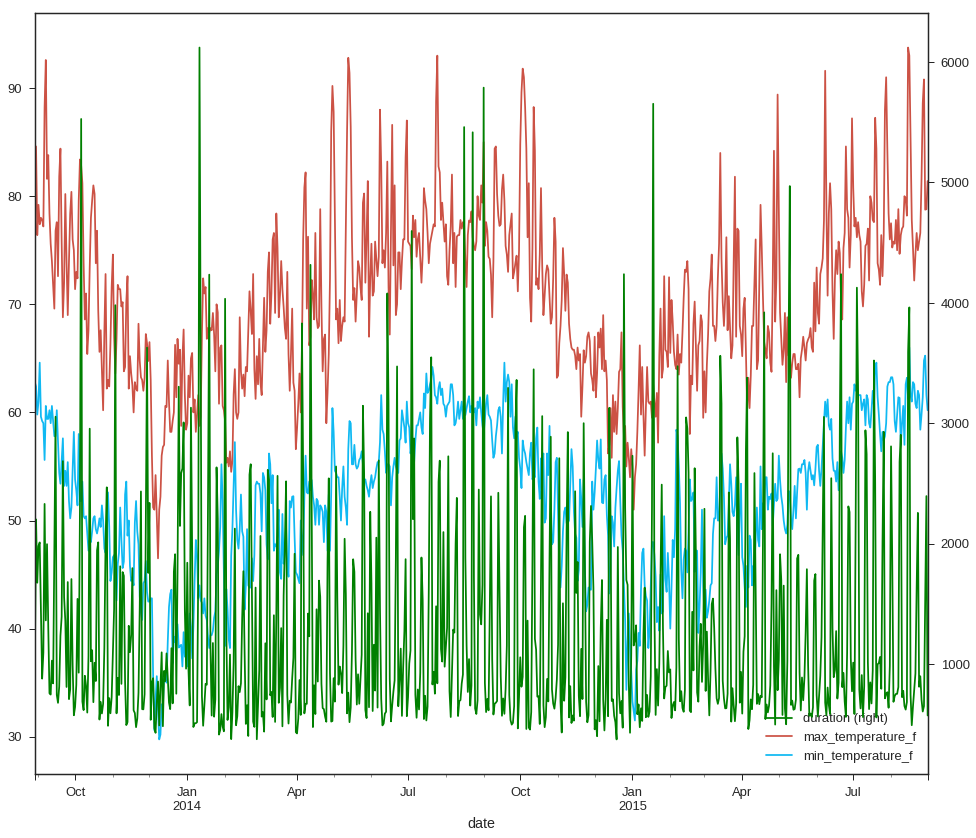

In [27]:
dfTrip_N_WeatherGeneral = dfTrip_N_Weather.sort_values(by=['date'])
dfTrip_N_WeatherGeneral[['date', 'duration', 'max_temperature_f', 'min_temperature_f']]\
                        .groupby(by=['date'])\
                        .agg('mean')\
                        .reset_index()\
                        .plot(x='date',\
                              kind='line',\
                              secondary_y='duration',\
                              figsize=(16,14),\
                              color=['g', '#cc5245', '#10b9f2']
                              )
plt.show()

### Plot General fecha a fecha ↑ :
**En principio este gráfico es muy confuso, por la cantidad de registros que hay.**  
Lo que podemos hacer a continuación es, realizar el mismo grafico pero con los promedios de duraciones mes a mes, de esta forma obtendremos un gráfico más sobrio.

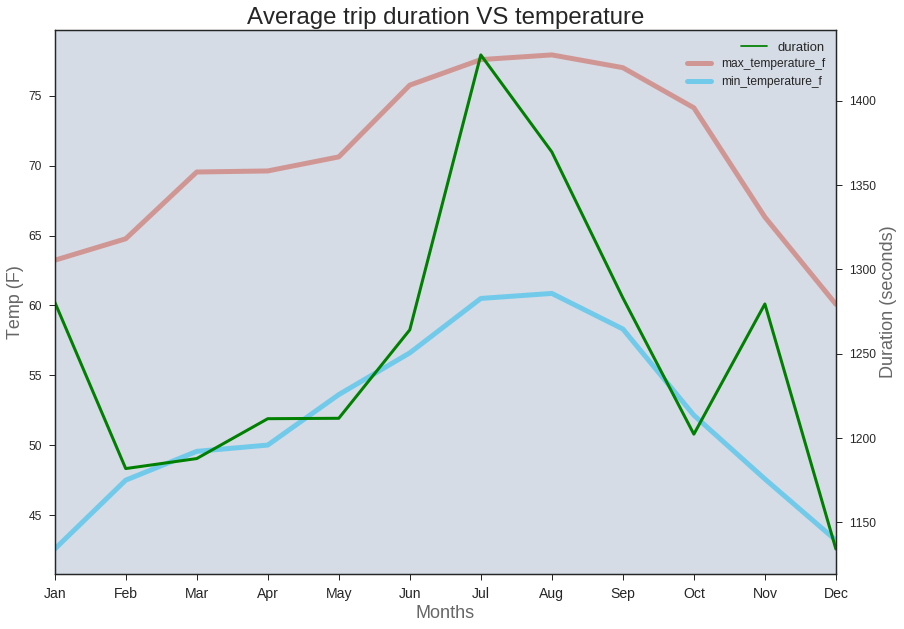

In [28]:
dfTrip_N_WeatherGeneral.date = dfTrip_N_WeatherGeneral.date.dt.month
ax = dfTrip_N_WeatherGeneral[['date', 'duration', 'max_temperature_f', 'min_temperature_f']]\
                    .groupby(by=['date'])\
                    .agg('mean')\
                    .reset_index()\
                    .plot(kind='line',\
                          x='date',\
                          secondary_y='duration',\
                          figsize=(14,10),\
                          color=['g', '#cc5245', '#10b9f2'])

for line in ax.get_lines() :
    line.set_linewidth(5)
    line.set_antialiased(True)
    line.set_alpha(0.5)

ax.legend(fontsize=12, bbox_to_anchor=(1, 0.968))
ax.right_ax.legend(fontsize=13)
ax.right_ax.get_lines()[0].set_linewidth(3)
ax.right_ax.set_ylabel("Duration (seconds)", fontsize=18, alpha=0.7)

for yticklabel in ax.right_ax.get_yticklabels() :
    yticklabel.set_size(12)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
ax.set_xlabel("Months", fontsize=18, alpha=0.7)
ax.set_ylabel("Temp (F)", fontsize=18, alpha=0.7)

for xticklabel in ax.get_yticklabels() :
    xticklabel.set_size(12)
    
ax.set_facecolor('#afbacc')
ax.patch.set_alpha(0.5)
plt.title('Average trip duration VS temperature', fontsize=24)
plt.show()

### Plot General mes a mes ↑ :
Plot de mes a mes los promedios de duraciones de todos los viajes (5 ciudades) tomando en cuenta los 3 años.
#### Observaciones:
+ Podemos resaltar que los viajes de mayor duración ocurrieron en Julio, época de mayor calor.
+ Además Julio-Agosto es la época en donde California se encuentra más llena de turistas quienes son los que         realizan los viajes de mayores duraciones ya que la mayoría de la gente que usa las bicis como medio de             transporte hacia su trabajo no superan los 30 minutos de viaje.
+ La caída en septiembre y octubre puede deberse a que comienzan las clases en esa época, por lo que los alumnos     quizas no utilizan las bicicletas durante el período lectivo.

### Armo 5 DataFrames para poder plotear cada ciudad por separado

In [29]:
dfRedwood = makeNewDataFrameWithCity(dfTrip_N_Weather, 'Redwood City')
dfSanFrancisco = makeNewDataFrameWithCity(dfTrip_N_Weather, 'San Francisco')
dfSanJose = makeNewDataFrameWithCity(dfTrip_N_Weather, 'San Jose')
dfMountainView = makeNewDataFrameWithCity(dfTrip_N_Weather, 'Mountain View')
dfPaloAlto = makeNewDataFrameWithCity(dfTrip_N_Weather, 'Palo Alto')
print len(dfRedwood), len(dfSanFrancisco), len(dfSanJose), len(dfMountainView), len(dfPaloAlto)

640 733 733 725 719


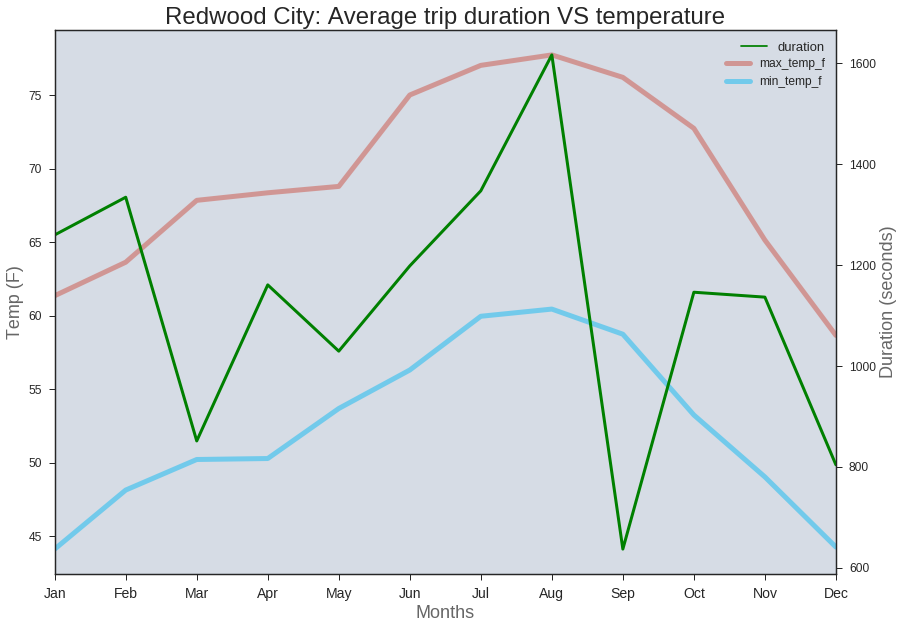

In [30]:
dfRedwood.date = dfRedwood.date.dt.month
dfRedwood = dfRedwood[['date', 'duration', 'max_temp_f', 'min_temp_f']]
ax = dfRedwood.groupby(by=['date'])\
              .agg('mean')\
              .reset_index()\
              .plot(kind='line',\
                    x='date',\
                    secondary_y='duration',\
                    figsize=(14,10),\
                    color=['g', '#cc5245', '#10b9f2'])
            
for line in ax.get_lines() :
    line.set_linewidth(5)
    line.set_antialiased(True)
    line.set_alpha(0.5)

ax.legend(fontsize=12, bbox_to_anchor=(1, 0.968))
ax.right_ax.legend(fontsize=13)
ax.right_ax.get_lines()[0].set_linewidth(3)
ax.right_ax.set_ylabel("Duration (seconds)", fontsize=18, alpha=0.7)

for yticklabel in ax.right_ax.get_yticklabels() :
    yticklabel.set_size(12)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
ax.set_xlabel("Months", fontsize=18, alpha=0.7)
ax.set_ylabel("Temp (F)", fontsize=18, alpha=0.7)

for xticklabel in ax.get_yticklabels() :
    xticklabel.set_size(12)
    
ax.set_facecolor('#afbacc')
ax.patch.set_alpha(0.5)

plt.title('Redwood City: Average trip duration VS temperature', fontsize=24)
plt.show()

### Reedwood City ↑ :
Pareciera estar coincidiendo con el esquema general anterior en las siguientes componentes:

+ Pico de duraciones en Agosto.
+ Decremento drástico en Septiembre.

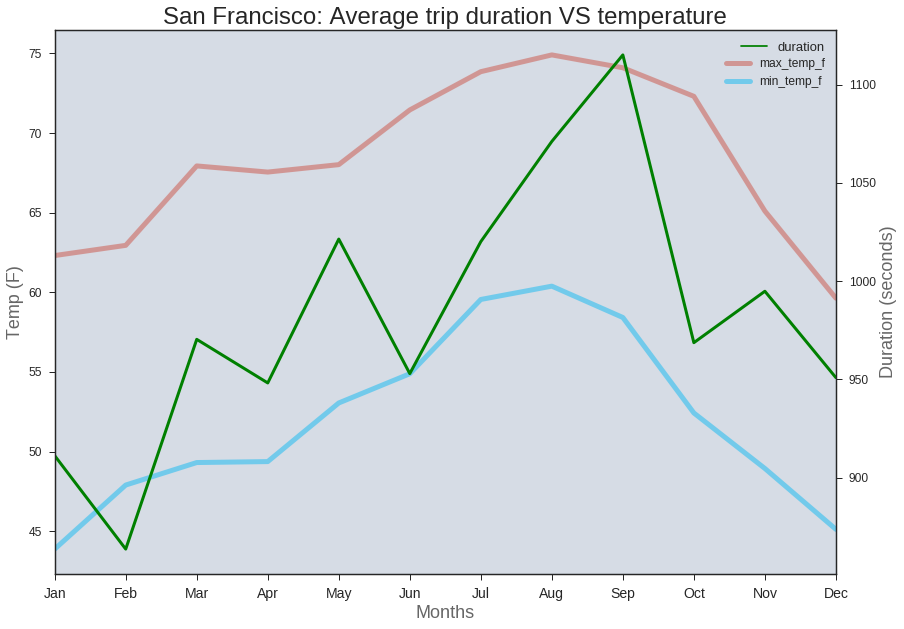

In [32]:
dfSanFrancisco.date = dfSanFrancisco.date.dt.month
dfSanFrancisco = dfSanFrancisco[['date', 'duration', 'max_temp_f', 'min_temp_f']]
ax = dfSanFrancisco.groupby(by=['date'])\
              .agg('mean')\
              .reset_index()\
              .plot(kind='line',\
                    x='date',\
                    secondary_y='duration',\
                    figsize=(14,10),\
                    color=['g', '#cc5245', '#10b9f2'])
            
for line in ax.get_lines() :
    line.set_linewidth(5)
    line.set_antialiased(True)
    line.set_alpha(0.5)

ax.legend(fontsize=12, bbox_to_anchor=(1, 0.968))
ax.right_ax.legend(fontsize=13)
ax.right_ax.get_lines()[0].set_linewidth(3)
ax.right_ax.set_ylabel("Duration (seconds)", fontsize=18, alpha=0.7)

for yticklabel in ax.right_ax.get_yticklabels() :
    yticklabel.set_size(12)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
ax.set_xlabel("Months", fontsize=18, alpha=0.7)
ax.set_ylabel("Temp (F)", fontsize=18, alpha=0.7)

for xticklabel in ax.get_yticklabels() :
    xticklabel.set_size(12)
    
ax.set_facecolor('#afbacc')
ax.patch.set_alpha(0.5)

plt.title('San Francisco: Average trip duration VS temperature', fontsize=24)
plt.show()

### San Francisco ↑ :
San Francisco en cambio coincide con la suba en Agosto pero su pico máximo se ve en Septiembre.

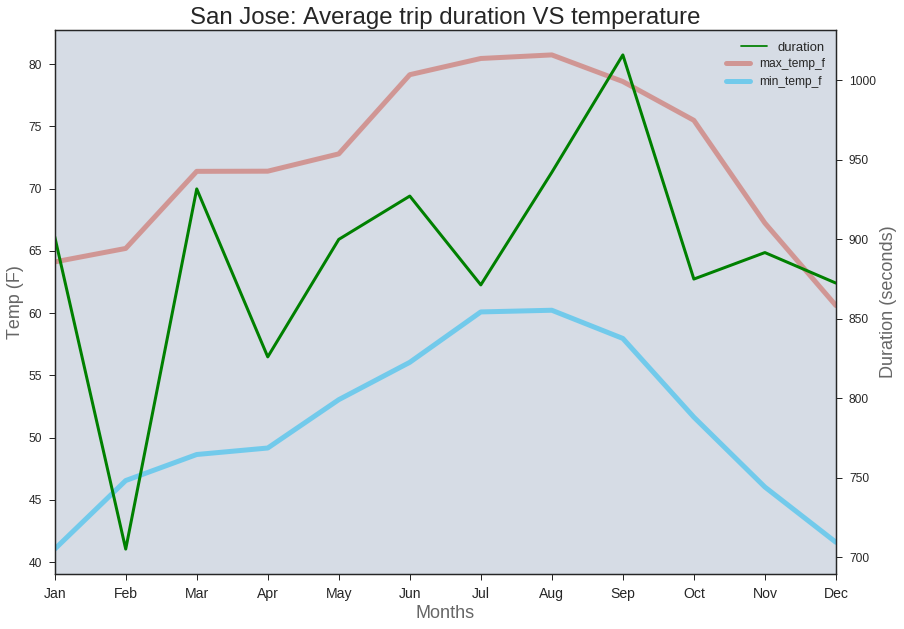

In [33]:
dfSanJose.date = dfSanJose.date.dt.month
dfSanJose = dfSanJose[['date', 'duration', 'max_temp_f', 'min_temp_f']]
ax = dfSanJose.groupby(by=['date'])\
              .agg('mean')\
              .reset_index()\
              .plot(kind='line',\
                    x='date',\
                    secondary_y='duration',\
                    figsize=(14,10),\
                    color=['g', '#cc5245', '#10b9f2'])
            
for line in ax.get_lines() :
    line.set_linewidth(5)
    line.set_antialiased(True)
    line.set_alpha(0.5)

ax.legend(fontsize=12, bbox_to_anchor=(1, 0.968))
ax.right_ax.legend(fontsize=13)
ax.right_ax.get_lines()[0].set_linewidth(3)
ax.right_ax.set_ylabel("Duration (seconds)", fontsize=18, alpha=0.7)

for yticklabel in ax.right_ax.get_yticklabels() :
    yticklabel.set_size(12)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
ax.set_xlabel("Months", fontsize=18, alpha=0.7)
ax.set_ylabel("Temp (F)", fontsize=18, alpha=0.7)

for xticklabel in ax.get_yticklabels() :
    xticklabel.set_size(12)
    
ax.set_facecolor('#afbacc')
ax.patch.set_alpha(0.5)

plt.title('San Jose: Average trip duration VS temperature', fontsize=24)
plt.show()

### San Jose ↑ :
Otra vez vemos que coincide que los viajes de mayor duración se ven en Agosto-Septiembre en la época de mayor temperatura, esto ya no es coincidencia.

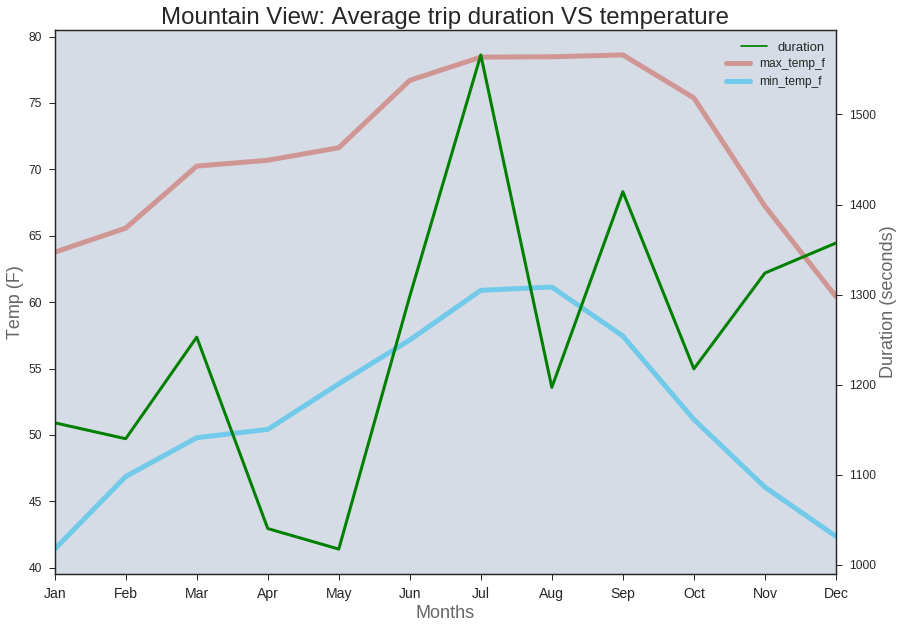

In [34]:
dfMountainView.date = dfMountainView.date.dt.month
dfMountainView = dfMountainView[['date', 'duration', 'max_temp_f', 'min_temp_f']]
ax = dfMountainView.groupby(by=['date'])\
              .agg('mean')\
              .reset_index()\
              .plot(kind='line',\
                    x='date',\
                    secondary_y='duration',\
                    figsize=(14,10),\
                    color=['g', '#cc5245', '#10b9f2'])
            
for line in ax.get_lines() :
    line.set_linewidth(5)
    line.set_antialiased(True)
    line.set_alpha(0.5)

ax.legend(fontsize=12, bbox_to_anchor=(1, 0.968))
ax.right_ax.legend(fontsize=13)
ax.right_ax.get_lines()[0].set_linewidth(3)
ax.right_ax.set_ylabel("Duration (seconds)", fontsize=18, alpha=0.7)

for yticklabel in ax.right_ax.get_yticklabels() :
    yticklabel.set_size(12)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
ax.set_xlabel("Months", fontsize=18, alpha=0.7)
ax.set_ylabel("Temp (F)", fontsize=18, alpha=0.7)

for xticklabel in ax.get_yticklabels() :
    xticklabel.set_size(12)
    
ax.set_facecolor('#afbacc')
ax.patch.set_alpha(0.5)

plt.title('Mountain View: Average trip duration VS temperature', fontsize=24)
plt.show()

### Mountain View ↑ :
Reafirmando lo visto por el gráfico general y los casos particulares de las ciudades anteriores, definitivamente los viajes con mayores duraciones se dan a temperaturas mayores.

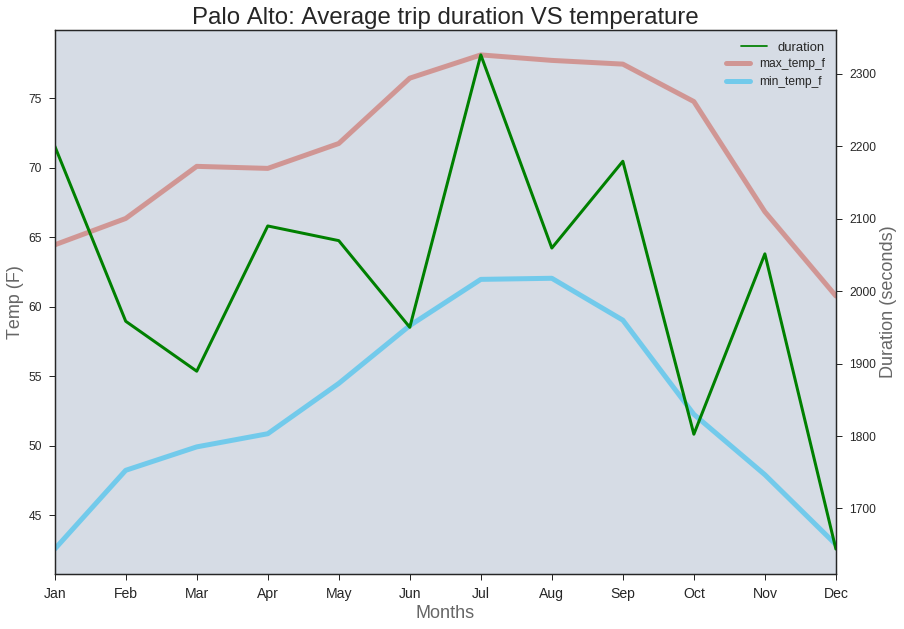

In [35]:
dfPaloAlto.date = dfPaloAlto.date.dt.month
dfPaloAlto = dfPaloAlto[['date', 'duration', 'max_temp_f', 'min_temp_f']]
ax = dfPaloAlto.groupby(by=['date'])\
              .agg('mean')\
              .reset_index()\
              .plot(kind='line',\
                    x='date',\
                    secondary_y='duration',\
                    figsize=(14,10),\
                    color=['g', '#cc5245', '#10b9f2'])
            
for line in ax.get_lines() :
    line.set_linewidth(5)
    line.set_antialiased(True)
    line.set_alpha(0.5)

ax.legend(fontsize=12, bbox_to_anchor=(1, 0.968))
ax.right_ax.legend(fontsize=13)
ax.right_ax.get_lines()[0].set_linewidth(3)
ax.right_ax.set_ylabel("Duration (seconds)", fontsize=18, alpha=0.7)

for yticklabel in ax.right_ax.get_yticklabels() :
    yticklabel.set_size(12)

ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=14)
ax.set_xlabel("Months", fontsize=18, alpha=0.7)
ax.set_ylabel("Temp (F)", fontsize=18, alpha=0.7)

for xticklabel in ax.get_yticklabels() :
    xticklabel.set_size(12)
    
ax.set_facecolor('#afbacc')
ax.patch.set_alpha(0.5)

plt.title('Palo Alto: Average trip duration VS temperature', fontsize=24)
plt.show()

### Palo Alto ↑ :
Quizas el caso más conflictivo es en esta ciudad, donde el comportamiento de las duraciones de los viajes es bastante errático. Mantiene lo ya identificado: **la mayor duración de los viajes en la época más calurosa**, sin embargo, en diciembre y enero presenta viajes bastante largos con temperaturas bajas.